# Predicting Steam Game Prices

The goal of this project is to analyze **whether game attributes can accurately predict pricing on the Steam marketplace.**

Some of the key questions I aim to answer:

- 💰 **Predictive Power:** How effectively, if at all, can structured attributes predict game prices?
- 📈 **Feature Impact:** Which features have the strongest influence on pricing? What do they say about pricing trends?
- 🎮 **Market Insights:** What do pricing patterns reveal about the gaming market and consumer behavior?
- 🔍 **Model Comparison:** How do different regression approaches compare in capturing pricing dynamics?

---

## 📊 Modeling & Methodology

1️⃣ **Target Definition:** Predict the Original Price (€) of Steam games using regression models.

2️⃣ **Feature Engineering:** Transform raw Steam data into model-ready features.

3️⃣ **Model Development:** Train and compare multiple regression models: Linear Regression, Ridge Regression, Random Forest, and Gradient Boosting.

4️⃣ **Evaluation & Insights:** Use RMSE and R² to evaluate models and identify which features drive pricing decisions.

---

## 🧮 What is Regression?

**Regression** is a supervised learning technique for predicting continuous values (like prices), as opposed to classification, which predicts categories.

**Linear regression** models relationships between features and the target as a linear equation: **y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε**
- y is the predicted price.
- β values are learned coefficients.
- x values are features. 
- ε represents error.

---

## Section 1: Data & Feature Engineering

Before building any models, we need to understand our data. We'll check for data quality issues, understand distributions, and identify relationships between features and our target (original price).

In [1311]:
# Import necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

# Scikit-learn modules for regression.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, max_error
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

To get started, we'll import the dataset for this analysis. It can be found inside the .zip folder of this notebook.

In [1312]:
# Load & prepare data.
steam_sales = pd.read_csv('steam_sales_Sep28.csv')

# Column names & row quantity. 
print("Columns:", list(steam_sales.columns))
print("Rows:", steam_sales.shape[0])

Columns: ['Game Name', 'Rating', '#Reviews', 'Discount%', 'Price (€)', 'Original Price (€)', 'Release Date', 'Windows', 'Linux', 'MacOS', 'Fetched At']
Rows: 2543


First, we'll check for null and duplicate values, as well as the data types.

In [1313]:
# Check for null and duplicate values. 
print("Nulls:", steam_sales.isnull().values.any())
print("Duplicates:", steam_sales[steam_sales['Game Name'].duplicated(keep=False)].values.any())

Nulls: False
Duplicates: True


Data is pulled directly from the Steam API and appends new data once a week, so the absence of null values and the presence of duplicates are both expected.

In [1314]:
# Filter for duplicates.
steam_sales = steam_sales.sort_values('Fetched At', ascending = False)
steam_sales = steam_sales.drop_duplicates(subset=['Game Name'], keep='first')
steam_sales = steam_sales.reset_index(drop=True)

# Check for nulls and duplicates once more.
print("Nulls:", steam_sales.isnull().values.any())
print("Duplicates:", steam_sales[steam_sales['Game Name'].duplicated(keep=False)].values.any())

Nulls: False
Duplicates: False


Duplicate values have been removed. Using the Fetched At column, we sorted recent updates to the top, then kept only the first iteration.

In [1315]:
# Check data types.
print(steam_sales.dtypes.to_string())

Game Name              object
Rating                float64
#Reviews               object
Discount%             float64
Price (€)             float64
Original Price (€)    float64
Release Date           object
Windows                 int64
Linux                   int64
MacOS                   int64
Fetched At             object


The Release Date, Fetched At, and Reviews columns are stored as objects (strings). 

- Reviews will be converted to numeric, as it represents quantitative data. 

- Release Date & Fetched At will be converted to datetime to take advantage of pandas’ time and date functionality.

In [1316]:
# Convert Reviews to numeric. 
steam_sales['#Reviews'] = pd.to_numeric(steam_sales['#Reviews'].str.replace(',', ''))

# Convert Fetched At to datetime.
steam_sales['Fetched At'] = pd.to_datetime(steam_sales['Fetched At'])

# Convert Release Date to datetime.  
date_format_1 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%b %d, %Y').dropna() # Month Day, Year.
date_format_2 = pd.to_datetime(steam_sales['Release Date'], errors='coerce', format = '%d %b, %Y').dropna() # Day Month, Year.
steam_sales['Release Date'] = pd.concat([date_format_2, date_format_1])

Finally, we'll call `.describe()` to double check the changes and get a sense of what we're working with.

In [1317]:
# Preview cleaned dataset. 
display(steam_sales.head(3))
display(steam_sales.describe().round(2))

,Game Name,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
0,Assetto Corsa - Dream Pack 2,7.0,289.0,-70.0,2.09,6.99,2015-10-08,1,0,0,2025-09-29 12:49:00
1,Marvel's Spider-Man 2 - Digital Deluxe Upgrade,5.0,65.0,-20.0,55.99,69.99,2025-01-30,1,0,0,2025-09-29 12:49:00
2,Way of the Hunter,7.0,3936.0,-50.0,14.99,29.99,2022-08-16,1,0,0,2025-09-29 12:49:00


,Rating,#Reviews,Discount%,Price (€),Original Price (€),Release Date,Windows,Linux,MacOS,Fetched At
count,1751.00,1751.00,1751.00,1751.00,1751.00,1751,1751.00,1751.00,1751.00,1751
mean,6.42,15569.72,-50.76,12.31,27.03,2021-12-06 19:35:11.479154944,0.99,0.18,0.28,2025-09-09 21:40:04.900057088
min,3.00,10.00,-95.00,0.53,2.99,2006-11-29 00:00:00,0.00,0.00,0.00,2025-08-11 00:00:00
25%,5.00,837.00,-75.00,5.99,14.99,2020-01-09 00:00:00,1.00,0.00,0.00,2025-09-02 11:23:00
50%,7.00,2623.00,-50.00,9.99,24.50,2023-03-07 00:00:00,1.00,0.00,0.00,2025-09-15 12:47:00
75%,7.00,11354.00,-30.00,15.99,34.99,2024-10-31 00:00:00,1.00,0.00,1.00,2025-09-22 12:47:00
max,8.00,1038433.00,-10.00,64.99,99.99,2025-09-28 00:00:00,1.00,1.00,1.00,2025-09-29 12:49:00
std,1.28,52329.56,23.53,8.80,15.76,NaN,0.07,0.39,0.45,NaN


Now that the data is clean, we'll create the target and feature variables we'll be modeling on. We'll create a separate dataframe for these variables and add Original Price (€) as the target, Price.

In [1318]:
# Creating analysis variables dataframe.
analysis_df = pd.DataFrame()

# Original Price (€) as target.
analysis_df['Price'] = steam_sales['Original Price (€)']

Before creating any features, let's explore the data distributions. We'll start with the review counts, as the data description indicates significant variation.

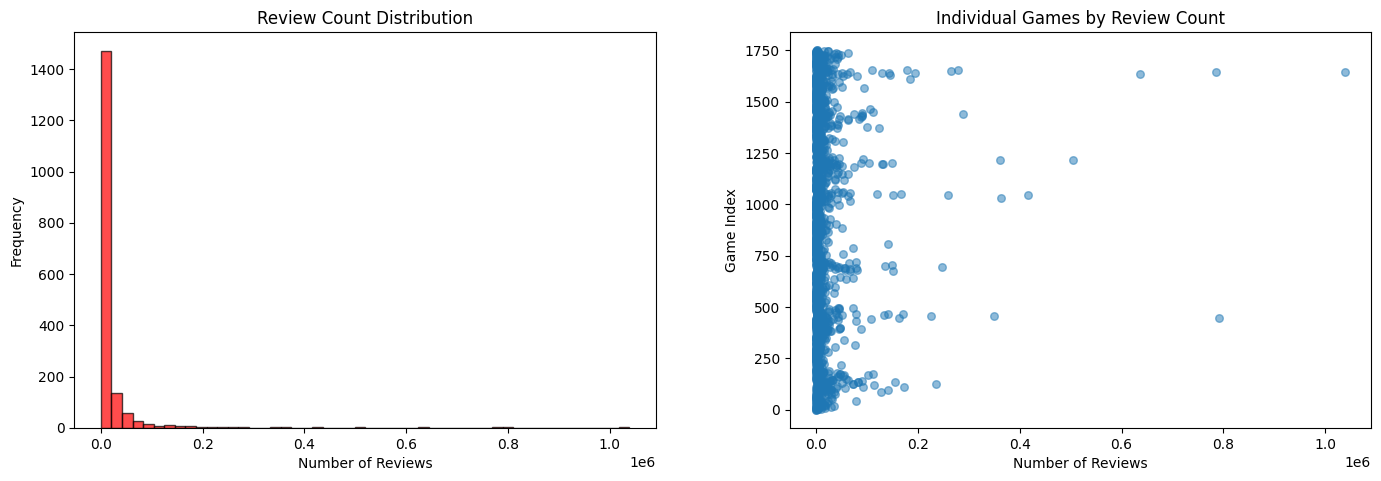

In [1319]:
# Reviews distribution visualizations.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

# Histogram.
ax1.hist(steam_sales['#Reviews'], bins=50, color='red', edgecolor='black', alpha=.7)
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('Frequency')
ax1.set_title('Review Count Distribution')

# Scatter plot.
ax2.scatter(steam_sales['#Reviews'], steam_sales.index, alpha=0.5, s=30)
ax2.set_xlabel('Number of Reviews')
ax2.set_ylabel('Game Index')
ax2.set_title('Individual Games by Review Count')

plt.tight_layout(pad=5.0)
plt.savefig('Output/review_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Looking at the Distribution of Reviews visuals, we can confirm a harsh skew. To use this data as a model feature, we'll evaluate 4 different transformations of Reviews data:
- Log-transformation: Compresses large values and stretches smaller ones. 
- Square Root: Moderate compression, less aggressive than log transforming. 
- Yeo-Johnson: Finds optimal transformation for given data. 
- Quantile Transformation: Forces perfect normal distribution.

In [1320]:
# Log transformation.
Log_Reviews = np.log1p(steam_sales['#Reviews'])

# Square root transformation.
Sqrt_Reviews = np.sqrt(steam_sales['#Reviews'])

# Yeo-Johnson transformation.
pt = PowerTransformer(method='yeo-johnson', standardize=False)
YeoJohnson_Reviews = pt.fit_transform(steam_sales['#Reviews'].values.reshape(-1, 1)).flatten()

# Quantile transformation.
qt = QuantileTransformer(output_distribution='normal', random_state=42)
Quantile_Reviews = qt.fit_transform(steam_sales['#Reviews'].values.reshape(-1, 1)).flatten()

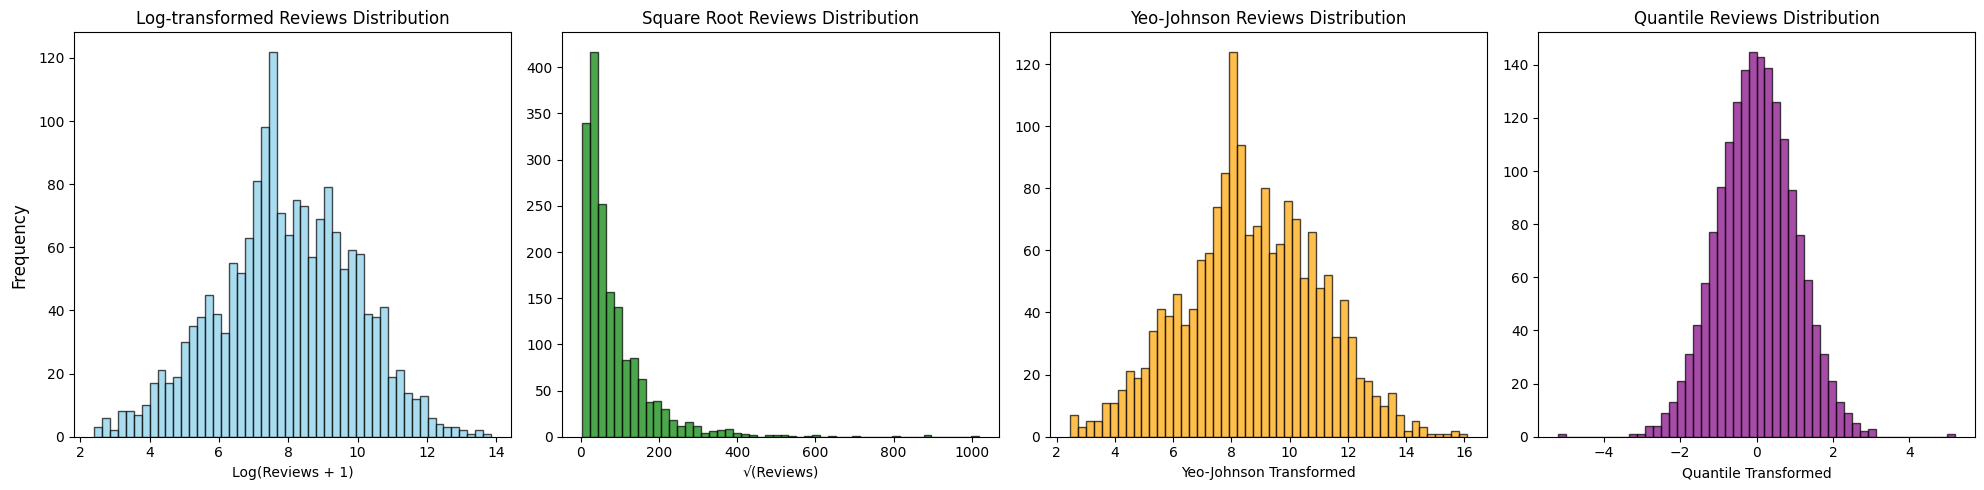

In [1321]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.supylabel('Frequency', x=0.01)

# Log-transformed Reviews.
axes[0].hist(Log_Reviews, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Log(Reviews + 1)')
axes[0].set_title('Log-transformed Reviews Distribution')

# Square root Reviews.
axes[1].hist(Sqrt_Reviews, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('√(Reviews)')
axes[1].set_title('Square Root Reviews Distribution')

# Yeo-Johnson Reviews.
axes[2].hist(YeoJohnson_Reviews, bins=50, color='orange', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Yeo-Johnson Transformed')
axes[2].set_title('Yeo-Johnson Reviews Distribution')

# Quantile Reviews.
axes[3].hist(Quantile_Reviews, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[3].set_xlabel('Quantile Transformed')
axes[3].set_title('Quantile Reviews Distribution')

plt.tight_layout()
plt.savefig('Output/transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

- Log and Yeo-Johnson have similar curves and more equitable distributions, though Log appears more compressed with a smaller range.

- Square root preserves the skew of the original data, but reduces the harshness.

- Quantile transformation forces a perfect bell-curve, likely missing significant distribution data. 

Based on skew alone, Log and Yeo-Johnson are good choices being the most evenly distributed. Before choosing the best transformation however, we'll check how each correlates with price. 

In [1322]:
# Create correlation test dataframe.
corr_data = pd.DataFrame({
    'Log_Reviews': Log_Reviews, 
    'Sqrt_Reviews': Sqrt_Reviews, 
    'YeoJohn_Reviews': YeoJohnson_Reviews, 
    'Quantile_Reviews': Quantile_Reviews, 
    'Original_Reviews': steam_sales['#Reviews'], 
    })

# Calculate price correlation. 
correlations = corr_data[['Log_Reviews', 'Sqrt_Reviews', 'YeoJohn_Reviews', 'Quantile_Reviews', 'Original_Reviews']].corrwith(analysis_df['Price']).abs()

print("Correlation with Price:")
print("-" * 28)
print(correlations.sort_values(ascending=False).to_string())

Correlation with Price:
----------------------------
Log_Reviews         0.313685
YeoJohn_Reviews     0.311878
Quantile_Reviews    0.310107
Sqrt_Reviews        0.219765
Original_Reviews    0.110947


The log-transformed data has the greatest correlation with price, and will be added to the variables dataframe as our Reviews feature.  

In [1323]:
# Log-transformation of Reviews as a feature.
analysis_df['Log_Reviews'] = Log_Reviews

# Ratings feature.
analysis_df['Rating'] = steam_sales['Rating']

# Release Date as Year & Month.
analysis_df['Year'] = steam_sales['Release Date'].dt.year
analysis_df['Month'] = steam_sales['Release Date'].dt.month

# Discount as an absolute value. 
analysis_df['Discount'] = steam_sales['Discount%'].abs()

# OS Support, with OS_Count added.
analysis_df['Windows'] = steam_sales['Windows']
analysis_df['Linux'] = steam_sales['Linux']
analysis_df['MacOS'] = steam_sales['MacOS']
analysis_df['OS_Count'] = analysis_df[['Windows','Linux','MacOS']].sum(axis=1)

analysis_df

,Price,Log_Reviews,Rating,Year,Month,Discount,Windows,Linux,MacOS,OS_Count
0,6.99,5.669881,7.0,2015,10,70.0,1,0,0,1
1,69.99,4.189655,5.0,2025,1,20.0,1,0,0,1
2,29.99,8.278174,7.0,2022,8,50.0,1,0,0,1
3,49.99,7.490529,8.0,2023,11,50.0,1,0,0,1
4,24.99,9.146015,5.0,2023,11,80.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1746,59.99,9.688684,4.0,2016,11,67.0,1,0,0,1
1747,20.99,7.192182,7.0,2021,7,60.0,1,0,0,1
1748,9.99,10.021048,8.0,2007,8,60.0,1,0,0,1
1749,20.99,7.872455,7.0,2020,8,75.0,1,0,0,1


The variables dataframe looks ready, but before building any models, we'll split data into train & test sets.

In [1324]:
# Separate features and target.
X = analysis_df.drop(columns=["Price"])
y = analysis_df["Price"]

# Split into train and test sets (80/20 split).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)} games")
print(f"Test set: {len(X_test)} games")

Training set: 1400 games
Test set: 351 games


## Section 2: Modeling & Experimentation

In this section, we'll build and experiment with various models. To evaluate model performance, we'll use 4 metrics:

- RMSE: Average prediction error in euros.
- R²: Proportion of variance explained by the model.
- Max Error: Largest single prediction error in euros.
- Within €10: Percent of predictions that fall within €10 of actual price.

*Note: For RMSE and Max Error, lower values are better. For R² and Within €10, higher values are better.*

---

**01: Linear Regression**

For our initial experiment, we'll use a simple linear regression model with all available features. This establishes a baseline for later comparison.

In [1325]:
# Linear Regression model.
scaler_lr = StandardScaler()
X_train_scaled_lr = scaler_lr.fit_transform(X_train)
X_test_scaled_lr = scaler_lr.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled_lr, y_train)

# Make predictions.
y_train_pred_lr = lr_model.predict(X_train_scaled_lr)
y_test_pred_lr = lr_model.predict(X_test_scaled_lr)

# Calculate metrics.
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
max_err_lr = max_error(y_test, y_test_pred_lr)
error_10_euro_lr = (np.mean(np.abs(y_test - y_test_pred_lr) <= 10) * 100)

# Calculate r2 gap.
r2_gap_lr = train_r2_lr - test_r2_lr

# Display results.
print("EXPERIMENT 1: Basic Linear Regression")
print("-" * 40)
print("Test Metrics:")
print(f"-RMSE: €{test_rmse_lr:.2f}")
print(f"-R²:   {test_r2_lr:.4f}")
print(f"-Max Error: €{max_err_lr:.2f}")
print(f"-Within €10: {error_10_euro_lr:.1f}%")
print("-" * 40)

# Check for overfitting.
print("Overfitting Check:")
print(f"-R² Gap: {r2_gap_lr:.3f} (positive = overfitting)")
print("-" * 40)

EXPERIMENT 1: Basic Linear Regression
----------------------------------------
Test Metrics:
-RMSE: €14.49
-R²:   0.2100
-Max Error: €75.41
-Within €10: 59.5%
----------------------------------------
Overfitting Check:
-R² Gap: 0.064 (positive = overfitting)
----------------------------------------


**Interpretation of Baseline:**

- RMSE: €14.49: On average, predictions are off by about €14.50, not great, but it does indicate *some* predictive power.
- R²: 0.21: Model explains only 21% of price variation, which is pretty low and suggests we're not capturing significant price factors.
- Max Error: €75.41: Worst prediction was off by over €75. The model can make significant errors on individual games.
- Within €10: 59.5%: About 60% of predictions were within a €10 margin. Not great for practical use, but suggests predictability. 


Bottom line, the basic linear regression model has minor predictive power. It *may* be able to provide a ballpark estimate, but it's missing critical factors that influence pricing.

---

**02: Ridge Regression**

The first experiment gave us a baseline, but linear regression can be sensitive to multicollinearity. For Experiment 2, we'll use Ridge Regression to reduce overfitting.

We'll start by applying StandardScaler to normalize features, then optimize regularization strength using logspace weight testing.

In [1326]:
# Scale selected features.
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train)
X_test_scaled2 = scaler2.transform(X_test)

# Test different alpha values.
alphas = np.logspace(-2, 3, 50) # 0.1 to 1000 
best_alpha = 1
best_rmse = float('inf')
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled2, y_train)
    pred = model.predict(X_test_scaled2) 
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print("Best alpha:", best_alpha.round(2))

Best alpha: 244.21


In [1327]:
# Ridge Regression model.
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train_scaled2, y_train)

# Make predictions.
y_train_pred_ridge = ridge_model.predict(X_train_scaled2)
y_test_pred_ridge = ridge_model.predict(X_test_scaled2)

# Calculate metrics.
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
max_err_ridge = max_error(y_test, y_test_pred_ridge)
error_10_euro_ridge = (np.mean(np.abs(y_test - y_test_pred_ridge) <= 10) * 100)

# Calculate r2 gap.
r2_gap_ridge = train_r2_ridge - test_r2_ridge

# Display results.
print("EXPERIMENT 2: Ridge Regression")
print("-" * 40)
print("Test Metrics:")
print(f"-RMSE: €{test_rmse_ridge:.2f}")
print(f"-R²:   {test_r2_ridge:.4f}")
print(f"-Max Error: €{max_err_ridge:.2f}")
print(f"-Within €10: {error_10_euro_ridge:.1f}%")
print("-" * 40)

# Check for overfitting.
print("Overfitting Check:")
print(f"-R² Gap: {r2_gap_ridge:.3f} (positive = overfitting)")
print("-" * 40)

# Compare test with baseline.
print("Change from Experiment 1:")
print(f"-RMSE: {((test_rmse_lr - test_rmse_ridge) / test_rmse_lr * 100):.2f}% {'better' if test_rmse_ridge < test_rmse_lr else 'worse'}, {test_rmse_ridge - test_rmse_lr:+.2f}")
print(f"-R²:   {((test_r2_ridge - test_r2_lr) / abs(test_r2_lr) * 100):.2f}% {'better' if test_r2_ridge > test_r2_lr else 'worse'}, {test_r2_ridge - test_r2_lr:+.4f}")
print("-" * 40)

EXPERIMENT 2: Ridge Regression
----------------------------------------
Test Metrics:
-RMSE: €14.33
-R²:   0.2278
-Max Error: €73.63
-Within €10: 60.4%
----------------------------------------
Overfitting Check:
-R² Gap: 0.032 (positive = overfitting)
----------------------------------------
Change from Experiment 1:
-RMSE: 1.13% better, -0.16
-R²:   8.49% better, +0.0178
----------------------------------------


- With an R² of 0.2278 and an R² Gap of 0.032, the second experiment is only a minor improvement suggesting overfitting was minimally impactful.

- Ridge Regression helps with regularization, but doesn't substantially improve predictive power.

---

**03: Random Forest Regression**

Since both experiments thus far have used linear models, the third experiment will use a Random Forest Regressor to account for non-linear patterns.

In [1328]:
# Random Forest with optimized parameters. 
rf_model = RandomForestRegressor(
    random_state=42,
    n_estimators=75,
    max_depth=5,
    min_samples_leaf=10,
    max_samples=0.6,
    max_features=0.4,
)

rf_model.fit(X_train, y_train)

# Make Predictions.
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics.
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
max_err_rf = max_error(y_test, y_test_pred_rf)
within_10_rf = (np.mean(np.abs(y_test - y_test_pred_rf) <= 10) * 100)

# Calculate r2 gap.
r2_gap_rf = train_r2_rf - test_r2_rf

# Display results.
print("EXPERIMENT 3: Random Forest Regression")
print("-" * 40)
print("Test Metrics:")
print(f"-RMSE: €{test_rmse_rf:.2f}")
print(f"-R²:   {test_r2_rf:.4f}")
print(f"-Max Error: €{max_err_rf:.2f}")
print(f"-Within €10: {within_10_rf:.1f}%")
print("-" * 40)

# Check for overfitting.
print("Overfitting Check:")
print(f"-R² Gap: {r2_gap_rf:.3f} (positive = overfitting)")
print("-" * 40)

# Compare with baseline.
print("Change from Experiment 1:")
print(f"-RMSE: {((test_rmse_lr - test_rmse_rf) / test_rmse_lr * 100):.2f}% {'better' if test_rmse_rf < test_rmse_lr else 'worse'}, {test_rmse_rf - test_rmse_lr:+.2f}")
print(f"-R²:   {((test_r2_rf - test_r2_lr) / abs(test_r2_lr) * 100):.2f}% {'better' if test_r2_rf > test_r2_lr else 'worse'}, {test_r2_rf - test_r2_lr:+.4f}")
print("-" * 40)

EXPERIMENT 3: Random Forest Regression
----------------------------------------
Test Metrics:
-RMSE: €14.05
-R²:   0.2572
-Max Error: €71.29
-Within €10: 60.4%
----------------------------------------
Overfitting Check:
-R² Gap: 0.025 (positive = overfitting)
----------------------------------------
Change from Experiment 1:
-RMSE: 3.03% better, -0.44
-R²:   22.49% better, +0.0472
----------------------------------------


- Even after aggressive regularization to reduce overfitting, the Random Forest achieved notably better results.

- Predictability is still poor, but the performance bump indicates significant non-linear relationships earlier models couldn't capture.

---

**04: Gradient Boosting Regression**

Since the Random Forest performed substantially better, our final experiment will test another non-linear model, Gradient Boosting.

In [1329]:
# Gradient Boosting with optimized parameters.
gb_model = GradientBoostingRegressor(
    random_state=42,
    n_estimators=75,
    max_depth=3,
    min_samples_leaf=15,
    learning_rate=0.05,
    subsample=0.5,
    max_features='sqrt',
)
gb_model.fit(X_train, y_train)

# Make predictions.
y_train_pred_gb = gb_model.predict(X_train)
y_test_pred_gb = gb_model.predict(X_test)

# Calculate metrics.
train_rmse_gb = np.sqrt(mean_squared_error(y_train, y_train_pred_gb))
test_rmse_gb = np.sqrt(mean_squared_error(y_test, y_test_pred_gb))
train_r2_gb = r2_score(y_train, y_train_pred_gb)
test_r2_gb = r2_score(y_test, y_test_pred_gb)
max_err_gb = max_error(y_test, y_test_pred_gb)
error_10_euro_gb = (np.mean(np.abs(y_test - y_test_pred_gb) <= 10) * 100)

# Calculate r2 gap.
r2_gap_gb = train_r2_gb - test_r2_gb

# Display results.
print("EXPERIMENT 4: Gradient Boosting Regression")
print("-" * 40)
print("Test Metrics:")
print(f"-RMSE: €{test_rmse_gb:.2f}")
print(f"-R²: {test_r2_gb:.4f}")
print(f"-Max Error: €{max_err_gb:.2f}")
print(f"-Within €10: {error_10_euro_gb:.1f}%")
print("-" * 40)

# Check for overfitting.
print("Overfitting Check:")
print(f"-R² Gap: {r2_gap_gb:.3f} (positive = overfitting)")
print("-" * 40)

# Compare with baseline.
print("Change from Experiment 1:")
print(f"-RMSE: {((test_rmse_lr - test_rmse_gb) / test_rmse_lr * 100):.2f}% {'better' if test_rmse_gb < test_rmse_lr else 'worse'}, {test_rmse_gb - test_rmse_lr:+.2f}")
print(f"-R²: {((test_r2_gb - test_r2_lr) / abs(test_r2_lr) * 100):.2f}% {'better' if test_r2_gb > test_r2_lr else 'worse'}, {test_r2_gb - test_r2_lr:+.4f}")
print("-" * 40)

EXPERIMENT 4: Gradient Boosting Regression
----------------------------------------
Test Metrics:
-RMSE: €13.90
-R²: 0.2734
-Max Error: €70.92
-Within €10: 61.5%
----------------------------------------
Overfitting Check:
-R² Gap: 0.049 (positive = overfitting)
----------------------------------------
Change from Experiment 1:
-RMSE: 4.09% better, -0.59
-R²: 30.17% better, +0.0634
----------------------------------------


--- 

## Section 3: Model Comparison

In this section, we'll visualize and compare the performance of all our models.

In [1330]:
# Create performance dataframe.
performance_df = pd.DataFrame(columns=['Model', 'RMSE', 'R²', 'Max_Error', 'Within_€10'])

# Add Linear Regression results.
performance_df.loc[0] = ['Linear Regression', test_rmse_lr, test_r2_lr, max_err_lr, error_10_euro_lr]

# Add Ridge Regression results.
performance_df.loc[1] = ['Ridge Regression', test_rmse_ridge, test_r2_ridge, max_err_ridge, error_10_euro_ridge]

# Add Random Forest results.
performance_df.loc[2] = ['Random Forest', test_rmse_rf, test_r2_rf, max_err_rf, within_10_rf]

# Add Gradient Boosting results.
performance_df.loc[3] = ['Gradient Boosting', test_rmse_gb, test_r2_gb, max_err_gb, error_10_euro_gb]

display(performance_df.round(3))

,Model,RMSE,R²,Max_Error,Within_€10
0,Linear Regression,14.493,0.210,75.406,59.544
1,Ridge Regression,14.329,0.228,73.633,60.399
2,Random Forest,14.054,0.257,71.288,60.399
3,Gradient Boosting,13.900,0.273,70.916,61.538


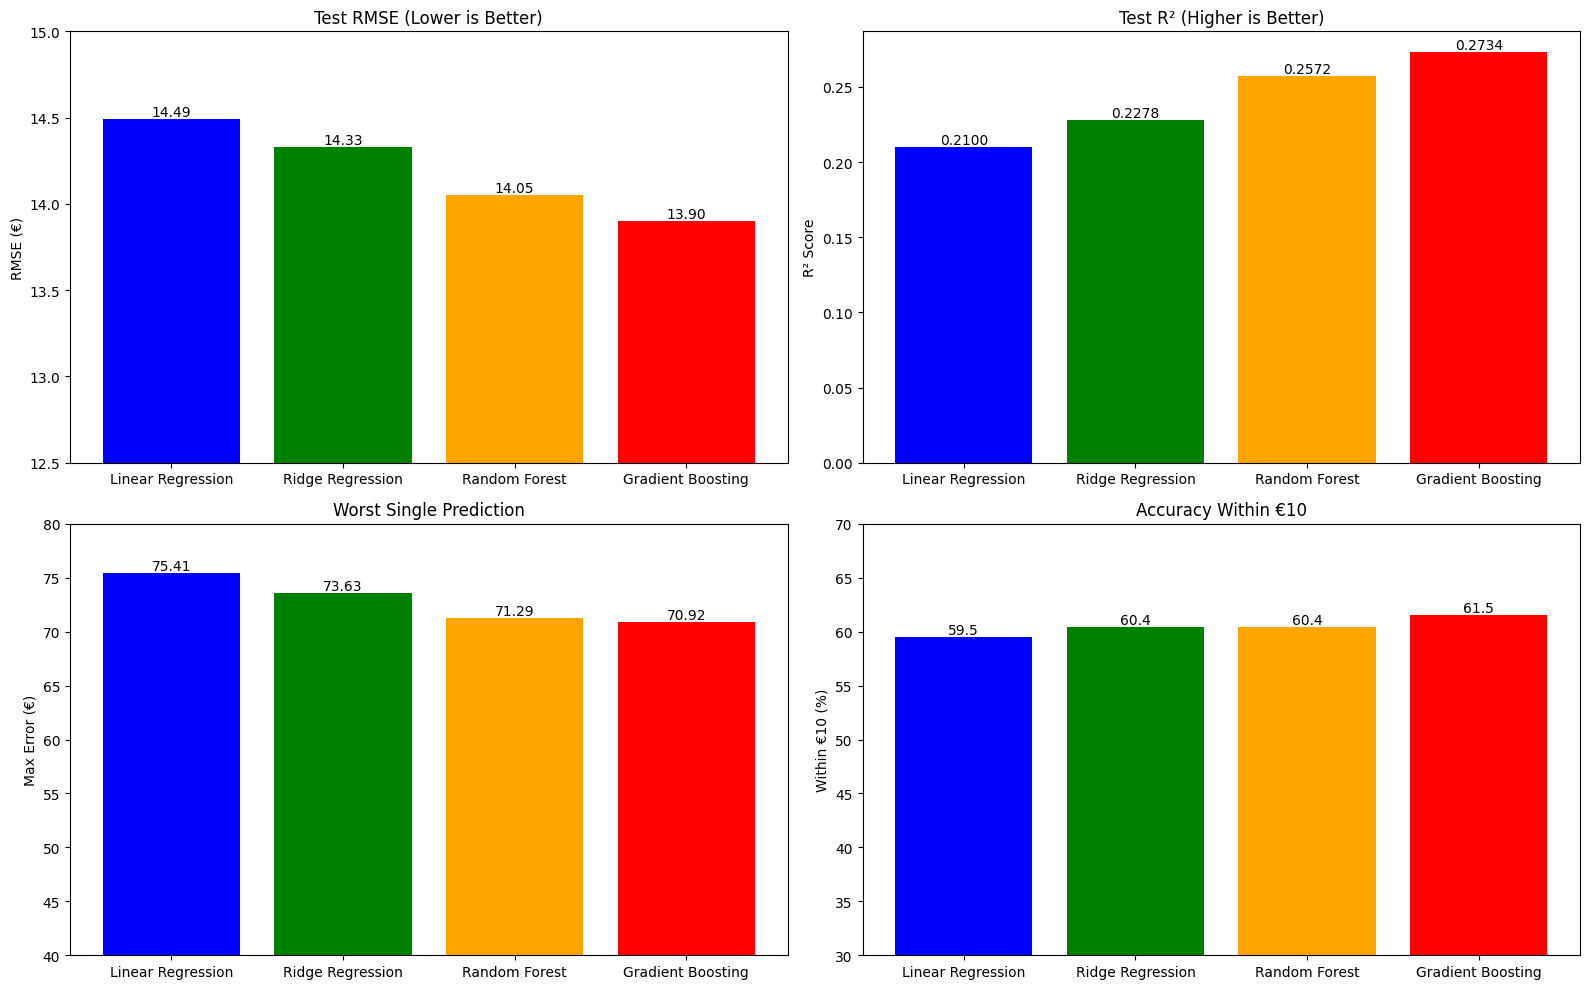

In [1331]:
# Model Performance Comparison Visualizations.
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# RMSE comparison.
bars1 = axes[0, 0].bar(performance_df['Model'], performance_df['RMSE'], color=['blue', 'green', 'orange', 'red'])
axes[0, 0].set_ylabel('RMSE (€)')
axes[0, 0].set_title('Test RMSE (Lower is Better)')
axes[0, 0].set_ylim(12.5, 15)
axes[0, 0].tick_params(axis='x')
axes[0, 0].bar_label(bars1, fmt='%.2f')

# R² comparison.
bars2 = axes[0, 1].bar(performance_df['Model'], performance_df['R²'], color=['blue', 'green', 'orange', 'red'])
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('Test R² (Higher is Better)')
axes[0, 1].tick_params(axis='x')
axes[0, 1].bar_label(bars2, fmt='%.4f')

# Max Error comparison.
bars3 = axes[1, 0].bar(performance_df['Model'], performance_df['Max_Error'], color=['blue', 'green', 'orange', 'red'])
axes[1, 0].set_ylabel('Max Error (€)')
axes[1, 0].set_title('Worst Single Prediction')
axes[1, 0].bar_label(bars3, fmt='%.2f')
axes[1, 0].tick_params(axis='x')
axes[1, 0].set_ylim(40, 80)

# Within €10 comparison.
bars4 = axes[1, 1].bar(performance_df['Model'], performance_df['Within_€10'], color=['blue', 'green', 'orange', 'red'])
axes[1, 1].set_ylabel('Within €10 (%)')
axes[1, 1].set_title('Accuracy Within €10')
axes[1, 1].bar_label(bars4, fmt='%.1f')
axes[1, 1].tick_params(axis='x')
axes[1, 1].set_ylim(30, 70)

plt.tight_layout()
plt.savefig('Output/model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

**Model Performance Summary:**
- Gradient Boosting outperforms all others, with €13.90 RMSE and 27% variance explained (30% better than linear regression).

- Both Random Forest and Gradient Boosting significantly outperform linear models, indicating substantial non-linear relationships in pricing.

- Small R² gaps across our models suggest good regularization and meaningful patterns. 

## Section 4: Feature Importance

In [1332]:
# Create feature importances.
lr_coefs = pd.DataFrame({'Feature': X.columns,'Coefficient': lr_model.coef_})
ridge_coefs = pd.DataFrame({'Feature': X.columns,'Coefficient': ridge_model.coef_})
rf_importance = pd.DataFrame({'Feature': X.columns,'Importance': rf_model.feature_importances_})
gb_importance = pd.DataFrame({'Feature': X.columns,'Importance': gb_model.feature_importances_})

# Create comprehensive dataframe.
feature_comparison = pd.DataFrame({
    'Feature': X.columns,
    'Linear_Regression': lr_coefs['Coefficient'].values,
    'Ridge_Regression': ridge_coefs['Coefficient'].values,
    'Random_Forest': rf_importance['Importance'].values,
    'Gradient_Boosting': gb_importance['Importance'].values
})

feature_comparison

,Feature,Linear_Regression,Ridge_Regression,Random_Forest,Gradient_Boosting
0,Log_Reviews,6.598768,5.001280,0.383928,0.404976
1,Rating,-2.901922,-2.292130,0.082976,0.109946
2,Year,5.290950,3.311459,0.106169,0.140327
3,Month,-0.118639,-0.311465,0.066523,0.057239
4,Discount,4.376450,3.331007,0.166367,0.148465
5,Windows,0.986788,0.924583,0.000000,0.000000
6,Linux,0.031222,-0.319263,0.017332,0.033605
7,MacOS,-1.941524,-1.649682,0.077409,0.059584
8,OS_Count,-1.052231,-1.063487,0.099297,0.045859


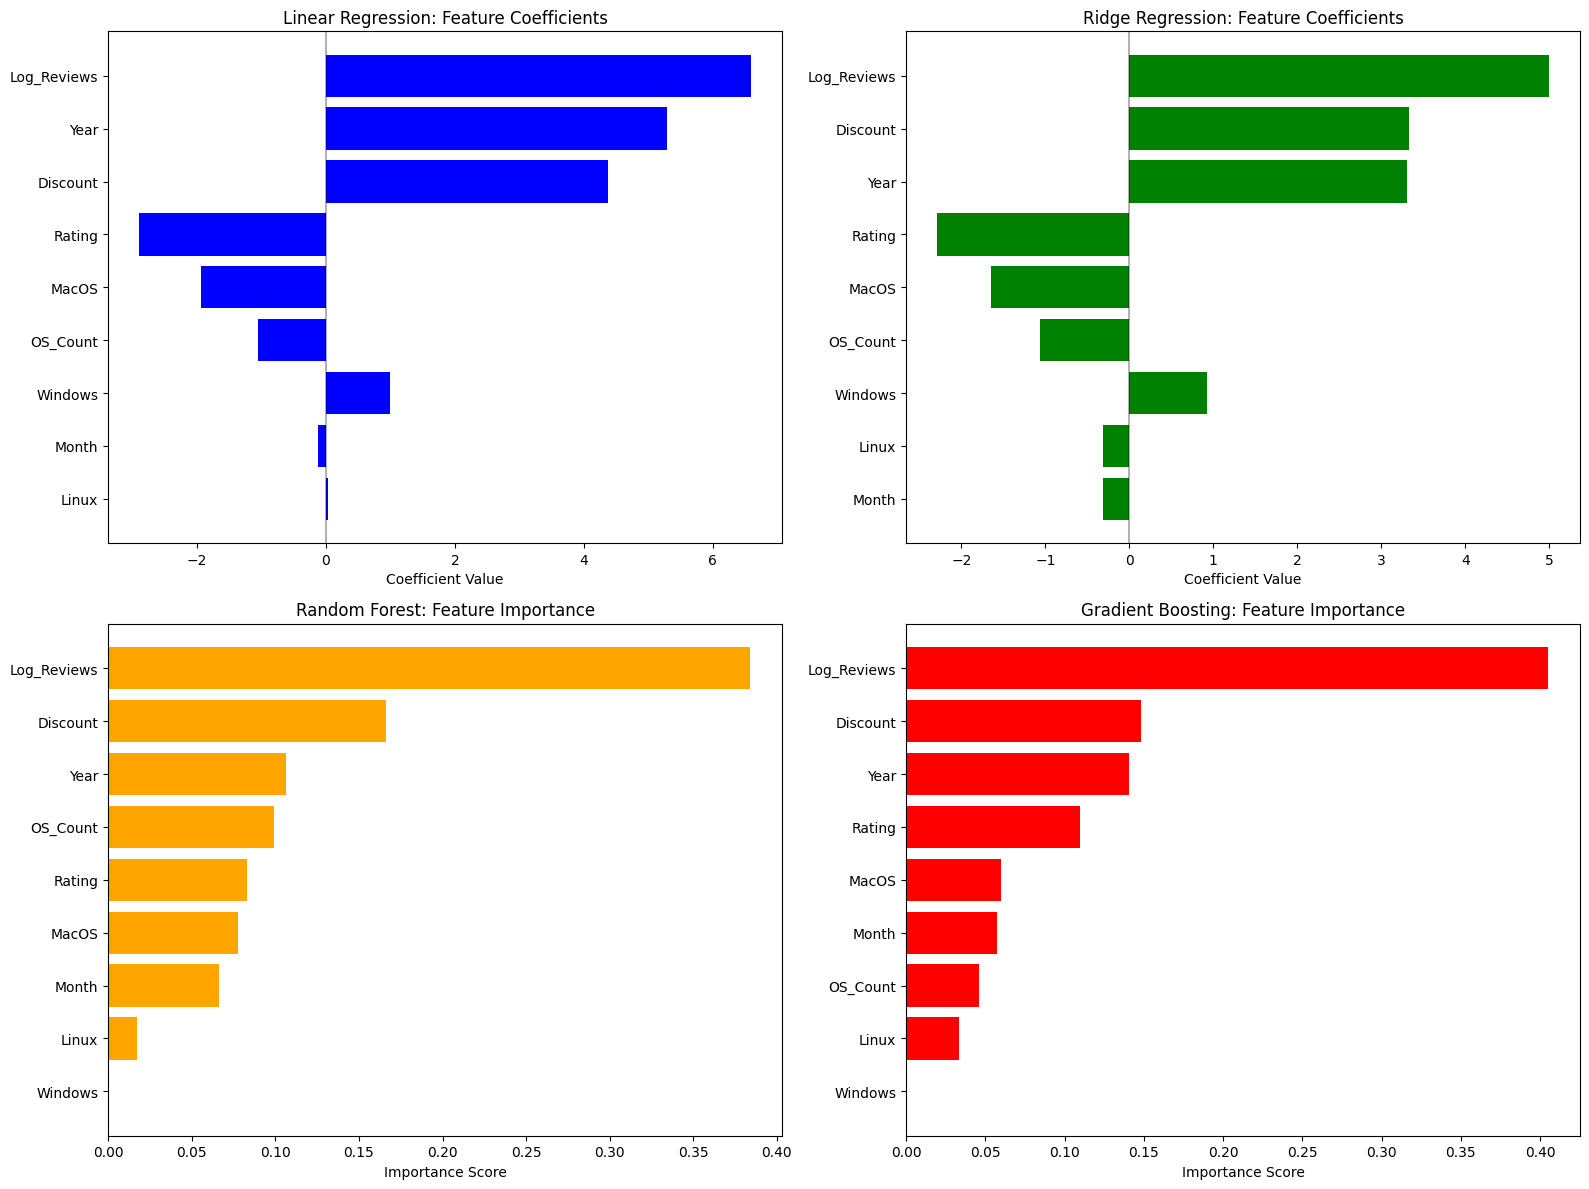

In [1333]:
# Feature importance visualizations.
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Linear Regression coefficients.
lr_sorted = feature_comparison.sort_values('Linear_Regression', key=abs, ascending=True)
axes[0, 0].barh(lr_sorted['Feature'], lr_sorted['Linear_Regression'], color='blue')
axes[0, 0].set_title('Linear Regression: Feature Coefficients')
axes[0, 0].set_xlabel('Coefficient Value')
axes[0, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Ridge Regression coefficients.
ridge_sorted = feature_comparison.sort_values('Ridge_Regression', key=abs, ascending=True)
axes[0, 1].barh(ridge_sorted['Feature'], ridge_sorted['Ridge_Regression'], color='green')
axes[0, 1].set_title('Ridge Regression: Feature Coefficients')
axes[0, 1].set_xlabel('Coefficient Value')
axes[0, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Random Forest feature importance.
rf_sorted = feature_comparison.sort_values('Random_Forest', ascending=True)
axes[1, 0].barh(rf_sorted['Feature'], rf_sorted['Random_Forest'], color='orange')
axes[1, 0].set_title('Random Forest: Feature Importance')
axes[1, 0].set_xlabel('Importance Score')

# Gradient Boosting feature importance.
gb_sorted = feature_comparison.sort_values('Gradient_Boosting', ascending=True)
axes[1, 1].barh(gb_sorted['Feature'], gb_sorted['Gradient_Boosting'], color='red')
axes[1, 1].set_title('Gradient Boosting: Feature Importance')
axes[1, 1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('Output/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Conclusion

**Model Performance:**
- Linear models struggled with the complex relationships inherent in game pricing, achieving about 21% variance explanation.
- Ensemble models outperform linear models, suggesting significant non-linear relationships.

**Feature Importance:**
- Reviews is by far the strongest predictor, indicating user engagement drives pricing decisions.
- Discount data was substantial, reflecting pricing strategy patterns.
- Release Year was consitently important, while Month was nearly redundant.
- Ratings and MacOS data were both surprisingly meaningful, with negative coefficients indicating negative relationships with price.

**Limitations & Next Steps:**
- Incorporate categorical features (genres, categories, tags) to capture genre-specific pricing.
- Include external variables, such as developer reputation, marketing budgets, and competitive landscape data.
- Further analyze pricing trends and market dynamics over time.

**References:**
- Dataset on Kaggle: https://www.kaggle.com/datasets/benjaminlundkvist/steam-sales-historical-dataset
- Steam store: https://store.steampowered.com/
- Yeo-Johnson Power Transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
- Quantile Transformer: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html